## Compute Stark effect for rotational levels of water molecule
Here we use the results from previous exercise "Compute rotational energy levels of rigid water molecule" as basis for computing rotational energies in the presence of static electric field.

The rotaitonal wave functions for water molecule, as an asymmetric-top, are represented by linear combinations of symmetric-top functions, i.e., $\psi_l^{(J,m)} = \sum_{k} c_k^{(J,l)}|J,k,m\rangle$, where $l$ is the index of rotaitonal state. These are eigenfunctions of rotational kinetic energy operator $T_\text{rot}$. The coefficients $c_k^{(J,l)}$ are stored in hdf5 file (previous exercise) as file['J:'+str(J)]['vec'] which returns a two-dimensional matrix with the first dimension being index of $k$ quantum number and the second - $l$. The corresponding list of $k$ quanta in stored as file['J:'+str(J)]['k_list'].

The Hamiltonian for molecule in static electric field is $H=T_\text{rot} - \sum_A\mu_A F_A$ ($A=X,Y,Z$ are laboratory frame axes), and we will be seeking for the eigenfunctions of $H$ in the form of linear combinations of field-free wave functions, i.e., generally $\Psi_n = \sum_{J,m,l} C_{J,m,l}^{(n)}\psi_l^{(J,m)}$, where $n$ is the index of field-dressed rotational state.

The task is to compute matrix representation of $H$ in the basis of eigenfunctions of $T_\text{rot}$, $\psi_l^{(J,m)}$ (rotational field-free states), and find its eigenvalues and eigenvectors. Repeat calculations for different values of electric field strength and plot the eigenvalues (field-dressed rotational energies) as functions of field.

We start by deriving the matrix representation of field-interaction Hamiltonian in the symmetric-top basis $\langle J',k',m'|-\sum_A\mu_A F_A|J,k,m\rangle$, which is given by $- \sum_A F_A \sum_\alpha \langle J',k',m' |R_{A,\alpha}| J,k,m\rangle \mu_\alpha$ ($\alpha =x,y,z$ are molecular frame axes), where $\mu_\alpha$ is molecular-frame dipole moment and $R_{A,\alpha}$ is direction cosine matrix.

The direction cosine matrix can be expressed in terms of Wigner D-matrix functions as $R_{A,\alpha} = \sum_{\sigma,\sigma'}[U^T]_{A,\sigma} D_{\sigma,\sigma'}^{(\omega)*} U_{\sigma',\alpha}$, where $U$ is the matrix transformation for the rank-1 Cartesian tensor operator into the spherical-tensor form, and $\sigma,\sigma'=-\omega .. \omega$.

Using the Wigner-Eckar theorem, the matrix elements $\langle J',k',m'|R_{A,\alpha}|J,k,m\rangle = \sum_{\sigma,\sigma'} [U^T]_{A,\sigma} (-1)^{m'+k'}\sqrt{2J'+1}\sqrt{2J+1}\left(\begin{array}{ccc}J&1&J'\\m&\sigma&-m'\end{array}\right)\left(\begin{array}{ccc}J&1&J'\\k&\sigma'&-k'\end{array}\right)U_{\sigma',\alpha}$.

For computaitonal efficiency, we can split this equation into two parts, i.e., $\langle J',k',m'|R_{A,\alpha}|J,k,m\rangle = M_A^{(J',m',J,m)}K_\alpha^{(J',k',J,k)}$, where $M_A^{(J',m',J,m)} = \sum_{\sigma} [U^T]_{A,\sigma} (-1)^{m'}\sqrt{2J'+1}\sqrt{2J+1}\left(\begin{array}{ccc}J&1&J'\\m&\sigma&-m'\end{array}\right)$ depends only on the laboratory frame quanta and $K_\alpha^{(J',k',J,k)} = \sum_{\sigma'}(-1)^{k'}\left(\begin{array}{ccc}J&1&J'\\k&\sigma'&-k'\end{array}\right)U_{\sigma',\alpha}$ depends only on the molecular frame quanta.

The transformation of symmetric-top matrix elements $\langle J',k',m'|R_{A,\alpha}|J,k,m\rangle$ to a representation of $T_\text{rot}$ eigenfunctions $\psi_l^{(J,m)}$ (rotational field-free states) is now computationally efficient since only the elements of $K_\alpha^{(J',k',J,k)}$ part need to be transformed.

In [77]:
# Define molecular and field parameters

dipole = [0, -1.9, 0] # dipole moment of water in Debye
# please note the orientation of molecular axes in calculation of rotational states of water
# in the exercise "Compute rotational energy levels of rigid water molecule" to assign correct dipole components

conv_to_cm = 1.679201682918921e-05 # converts dipole[Debye] * field[V/cm] into cm^-1
# note on unit conversion: Debye = 1/c * 10^{-21} Coulomb * meter and Coulomb * Volt = Joule

In [78]:
# Set up functions for computing symmetric-top matrix elements of direction cosine matrix

import numpy as np
import sympy
from sympy.physics.wigner import wigner_3j

# matrix of transformation from Cartesian to spherical-tensor form for rank-1 operator
#    order of spherical components in rows: (1,1), (1,0), (1,-1)
#    order of Cartesian components in columns: x, y, z

umat = np.array( [[-1.0/np.sqrt(2.0), -1j/np.sqrt(2.0), 0.0], \
                  [0.0, 0.0, 1.0], \
                  [1.0/np.sqrt(2.0), -1j/np.sqrt(2.0), 0.0]], dtype=np.complex128)

# split symmetric-top matrix element of direction consine matrix into a product of two parts M and K
# this is computationally much more efficient since we can now treat the m- and k-dependent parts (laboratory
# and molecular frames' quanta) of basis separately, while the complete basis is produced by a Kronecker
# product of all m and all k quanta, i.e., may become very large

# K-matrix contracted with permanent dipole moment, i.e. sum_alpha(K_alpha * dipole_alpha)
def kmat(omega, J1, k1, J2, k2):
        threej = np.array([wigner_3j(J2, omega, J1, k2, sigma, -k1) \
                           for sigma in reversed(range(-omega, omega + 1))], dtype=np.float64)
        return (-1.0)**k1 * np.dot(np.dot(threej, umat), dipole)

# M-matrix
def mmat(omega, J1, m1, J2, m2):
        threej = np.array([wigner_3j(J2, omega, J1, m2, sigma, -m1) \
                           for sigma in reversed(range(-omega, omega + 1))], dtype=np.float64)
        return np.sqrt(2.0 * J1 + 1) * np.sqrt(2.0 * J2 + 1) * (-1.0)**m1 * np.dot(np.linalg.pinv(umat), threej)

In [79]:
# Read from file previously computed rotational (field-free) states

import h5py
import re

filename = "water_states.h5"
print("read molecular field-free states from file:", filename)
k_list = {}
vec = {}
enr = {}
with h5py.File(filename, 'r') as file:
    for key in file:
        if re.match(r'J:(\w+)', key):
            Jstr = re.search('J:(\w+)', key).group(1)
            J = int(Jstr)
            print("read data for J =", J)
            k_list[J] = list(file[key]['k_list'][()])
            enr[J] = file[key]['enr'][()]
            vec[J] = file[key]['vec'][()]

read molecular field-free states from file: water_states.h5
read data for J = 0
read data for J = 1
read data for J = 10
read data for J = 2
read data for J = 3
read data for J = 4
read data for J = 5
read data for J = 6
read data for J = 7
read data for J = 8
read data for J = 9


In [80]:
# Set up basis quanta and precompute matrices composing the total Hamiltonian
# the benefits of splitting the matrix element of direction cosine matrix becomes apparent here!

Jmax = 5 # restrict maximal J spanned by basis, if necessary

# list of J quanta spanned by basis
J_list = [J for J in enr.keys() if J <= Jmax]

# list of m-quanta spanned by basis for each J
m_list = {J : [m for m in range(-J, J + 1)] for J in J_list}

# precompute matrix representation of Trot, which is diagonal in its own eigenbasis
h0 = {}
for J in J_list:
    h0[J] = [e for m in m_list[J] for e in enr[J]]

# precompute M and K matrices
mme = {}
kme = {}
for J1 in J_list:
    for J2 in J_list:
        # K-matrix in symmetric-top basis
        me = np.array([[ kmat(1, J1, k1, J2, k2) for k2 in k_list[J2] ] for k1 in k_list[J1] ]) # shape = (k', k)

        # transform K matrix to a basis of Trot eigenfunctions, i.e., rotational wavefunctions of water
        kme[(J1, J2)] = np.dot(np.conjugate(vec[J1].T), np.dot(me, vec[J2])) # shape = (l', l)

        # M-matrix in symmetric-top basis
        mme[(J1, J2)] = np.array([[ mmat(1, J1, m1, J2, m2) for m2 in m_list[J2] ] for m1 in m_list[J1] ]) # shape = (m', m, A)

do fz = 0.0 kV/cm ...
do fz = 1.1111111111111112 kV/cm ...
do fz = 2.2222222222222223 kV/cm ...
do fz = 3.3333333333333335 kV/cm ...
do fz = 4.444444444444445 kV/cm ...
do fz = 5.555555555555555 kV/cm ...
do fz = 6.666666666666667 kV/cm ...
do fz = 7.777777777777779 kV/cm ...
do fz = 8.88888888888889 kV/cm ...
do fz = 10.0 kV/cm ...


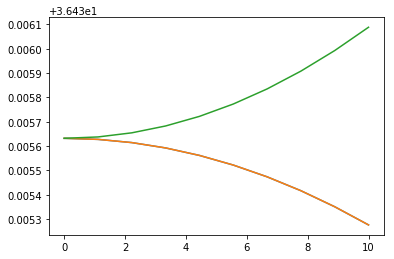

In [82]:
# Build and diagonalize the total Hamiltonian for external electric field on a grid

import matplotlib.pyplot as plt

stark = []

for Fz in np.linspace(0, 10, 10): # field in kV

    print("do fz =", Fz, "kV/cm ...")
    field = [0, 0, Fz * 1000] # field in V/cm

    # H' = -dipole * field = -sum_A(M_A * F_A) * K, convert to units cm^-1
    hmat = -np.block([[ np.kron( np.dot(mme[(J1, J2)], field), kme[(J1, J2)] ) * conv_to_cm \
                       for J2 in J_list] for J1 in J_list])
    # H = H0 + H'
    hmat += np.diag(np.concatenate([h0[J] for J in J_list]))

    # eigenvalues
    eigenval, eigenvec = np.linalg.eigh(hmat)

    stark.append([Fz, *eigenval])

stark = np.array(stark)

plt.plot(stark[:,0], stark[:,5])
plt.plot(stark[:,0], stark[:,6])
plt.plot(stark[:,0], stark[:,7])

We can now run same calculations using `watie` and `extfield`

In [83]:
# First, compute and store field-free rotational energies of water and matrix elements of dipole moment operator

from richmol.watie import RigidMolecule, SymtopBasis, Jxx, Jyy, Jzz, CartTensor

r1 = 0.96
r2 = 0.96
theta = 104.0 * np.pi / 180.0 # angle in radians

water = RigidMolecule()
water.XYZ = ("angstrom", \
             "O", 0, 0, 0, \
             "H", r1*np.sin(theta/2.0), 0, r1*np.cos(theta/2.0), \
             "H", -r2*np.sin(theta/2.0), 0, r2*np.cos(theta/2.0) )

water.tensor = ("dipole moment", [0, 0, -1.9])

water.frame = "pas"
Bx, By, Bz = water.B
print("Bx, By, Bz rotational constants in cm^-1:", Bx, By, Bz)

Jmax = 10

wavefunc = {}
for J in range(Jmax + 1):
    bas = SymtopBasis(J)

    # z=c, near-oblate
    H = Bx * Jxx(bas) + By * Jyy(bas) + Bz * Jzz(bas)
    hmat = bas.overlap(H)
    enr, vec = np.linalg.eigh(hmat.real)
    wavefunc[J] = bas.rotate(krot=(vec.T, enr))   # rotate basis to the eigenvector representation

# store rotational energies
for J in range(Jmax + 1):
    wavefunc[J].store_richmol("water_j0_j"+str(Jmax)+".h5")

mu = CartTensor(water.tensor["dipole moment"], name='mu', units='Debye')
    
# store rotational matrix elements of dipole moment
for J1 in range(Jmax + 1):
    for J2 in range(J1, Jmax + 1):
        if abs(J1-J2)>1: continue # selection rules
        mu.store_richmol(wavefunc[J1], wavefunc[J2], "water_j0_j"+str(Jmax)+".h5", thresh=1e-10)

Bx, By, Bz rotational constants in cm^-1: 26.958784982583502 14.614184327525283 9.476846602963152


do fz = 0.1 kV/cm ...
do fz = 1.2000000000000002 kV/cm ...
do fz = 2.3000000000000003 kV/cm ...
do fz = 3.4000000000000004 kV/cm ...
do fz = 4.5 kV/cm ...
do fz = 5.6 kV/cm ...
do fz = 6.7 kV/cm ...
do fz = 7.800000000000001 kV/cm ...
do fz = 8.9 kV/cm ...
do fz = 10.0 kV/cm ...


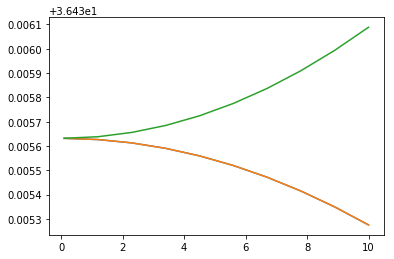

In [84]:
# Load field-free data and compute field-dressed states

from richmol.extfield import States, Tensor, Hamiltonian, mu_au_to_Cm, planck, c_vac
from richmol import rchm

Jmax = 5

richmol_file = "water_j0_j10.h5"

# field-free states
states = States(richmol_file, 'h0', [J for J in range(Jmax + 1)], emin=0, emax=10000)

# dipole matrix elements
mu = Tensor(richmol_file, 'mu', states, states)
mu.mul(-1.0)

stark = []

for Fz in np.linspace(0.1, 10, 10): # field in kV

    print("do fz =", Fz, "kV/cm ...")
    field = [0, 0, Fz * 1000 *100] # field in V/m

    # multiply dipole with external field
    mu2 = mu * field

    # convert dipole[au]*field[V/m] into [cm^-1]
    fac = mu_au_to_Cm / (planck * c_vac) / 100.0 * 0.393430307 # the last factor converts dipole from Debye to au
    mu2.mul(fac)

    # combine -dipole*field with field-free Hamiltonian
    ham = Hamiltonian(mu=mu2, h0=states)

    # matrix representation of Hamiltonian
    hmat = ham.tomat(form='full')

    # eigenvalues and eigenvectors
    enr, vec = np.linalg.eigh(hmat)

    stark.append([Fz, *enr])

stark = np.array(stark)

plt.plot(stark[:,0], stark[:,5])
plt.plot(stark[:,0], stark[:,6])
plt.plot(stark[:,0], stark[:,7])
